In [49]:
import torchhd
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm


In [ ]:
import sys
sys.path.append('..')
from shared_code.helpers import norm_hamming_similarity

In [50]:
vsa_types = ['FHRR', 'BSC', 'MAP', 'HRR', 'BSBC']
vsa_type = 'FHRR'
DIMENSIONS = [2**i for i in range(5, 13)]
BUNDLE_SIZES = list(range(2, 100, 2))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == 'cuda':
    torch.cuda.empty_cache()

batches = 10
item_memory_size = 1_000

In [51]:
## TODO: check if similar results because different norm_hammingsimilarity func in import
## TODO: also update similarity func to use package function

def norm_hamming_similarity(x, y):
    sim = torchhd.hamming_similarity(x, y)
    norm_sim = sim / x.shape[0]
    return norm_sim
similarity_func = norm_hamming_similarity if vsa_type in ['BSC'] else torchhd.cosine_similarity

### Evaluating non-normalized capacity of HD vectors

In [52]:
prob_correct_tensor = torch.zeros(len(DIMENSIONS), len(BUNDLE_SIZES), batches)

for batch in range(batches):
    perc_corr_array = torch.zeros(len(DIMENSIONS), len(BUNDLE_SIZES))
    # print(f'iteration: {batch + 1}')

    for d_idx in tqdm(range(len(DIMENSIONS))):
        dim = DIMENSIONS[d_idx]
        item_memory = torchhd.random(item_memory_size, dim, vsa=vsa_type, device=device)

        for k_idx in range(len(BUNDLE_SIZES)):
            k = BUNDLE_SIZES[k_idx]

            # sample k vectors from item memory and bundle them
            random_indices = torch.randperm(item_memory_size)[:k]
            to_bundle_vectors = item_memory[random_indices]

            bundle_vector = torchhd.multiset(to_bundle_vectors)

            # find the k nearest vectors to bundle
            similarities = similarity_func(bundle_vector, item_memory)
            k_nearest_vectors_idx = torch.topk(similarities, k, largest=True).indices

            # check if the k similar vectors are correct
            num_correct = np.intersect1d(k_nearest_vectors_idx.cpu().numpy(), random_indices.cpu().numpy()).shape[0]

            perc_corr_array[d_idx, k_idx] = num_correct / k
    
    # print(perc_corr_array)
    prob_correct_tensor[:, :, batch] = perc_corr_array
   
# compute mean and std over batches
prob_correct_mean = torch.mean(prob_correct_tensor, dim=2)
prob_correct_std = torch.std(prob_correct_tensor, dim=2)

100%|██████████| 8/8 [00:00<00:00, 19.21it/s]


Plotting results

Text(0.5, 1.0, 'Percentage of correctly retrieved bundled vectors; type FHRR vectors, 1000 items')

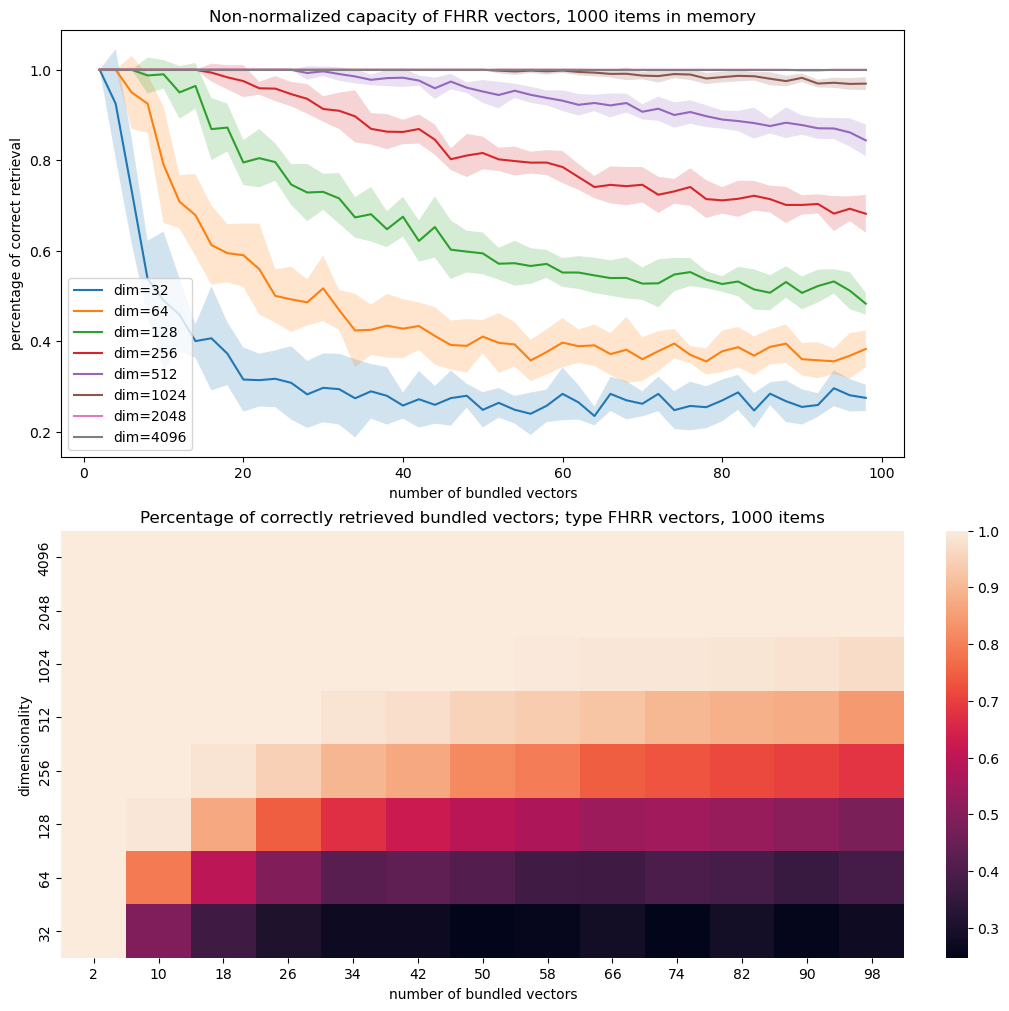

In [82]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10), layout='constrained')

line_ax = ax[0]
heatmap_ax = ax[1]

for d_idx in range(len(DIMENSIONS)):
    line_ax.plot(BUNDLE_SIZES, prob_correct_mean[d_idx, :], label=f'dim={DIMENSIONS[d_idx]}')
    line_ax.fill_between(BUNDLE_SIZES, prob_correct_mean[d_idx, :] - prob_correct_std[d_idx, :], prob_correct_mean[d_idx, :] + prob_correct_std[d_idx, :], alpha=0.2)
line_ax.legend()
line_ax.set_xlabel('number of bundled vectors')
line_ax.set_ylabel('percentage of correct retrieval')
line_ax.set_title(f'Non-normalized capacity of {vsa_type} vectors, {item_memory_size} items in memory')

# as a heatmap
# invert y axis to match the line plot
heatmap_ax = sns.heatmap(prob_correct_mean.numpy()[::-1, ::4],  xticklabels=BUNDLE_SIZES[::4], yticklabels=DIMENSIONS[::-1])
heatmap_ax.set_xlabel('number of bundled vectors')
heatmap_ax.set_ylabel('dimensionality')
heatmap_ax.set_title(f'Percentage of correctly retrieved bundled vectors; type {vsa_type} vectors, {item_memory_size} items')


### Capacity of unnormalized HD vectors

In [54]:
MAX_BUNDLE_SIZE = BUNDLE_SIZES[-1]
sim_first_vector_tensor = torch.zeros(len(DIMENSIONS), len(BUNDLE_SIZES), batches)
retrieval_first_vector_tensor = torch.zeros(len(DIMENSIONS), len(BUNDLE_SIZES), batches)

for batch in range(batches):
    sim_first_vector_array = torch.zeros(len(DIMENSIONS), len(BUNDLE_SIZES))
    retrieval_first_vector_array = torch.zeros(len(DIMENSIONS), len(BUNDLE_SIZES))
    # print(f'iteration: {batch + 1}')

    for d_idx in tqdm(range(len(DIMENSIONS))):
        dim = DIMENSIONS[d_idx]
        item_memory = torchhd.random(item_memory_size, dim, vsa=vsa_type, device=device)

        # sample MAX_BUNDLE_SIZE vectors from item memory
        random_indices = torch.randperm(item_memory_size)[:MAX_BUNDLE_SIZE]
        to_bundle_vectors = item_memory[random_indices]
        first_vector = to_bundle_vectors[0]
        bundle_vector = first_vector

        for k_idx in range(len(BUNDLE_SIZES)):
            prev_k = BUNDLE_SIZES[k_idx - 1] if k_idx > 0 else 0
            k = BUNDLE_SIZES[k_idx]

            # add vectors to bundle
            for i in range(prev_k, k):
                bundle_vector = torchhd.bundle(bundle_vector, to_bundle_vectors[i])

            # add similarity of first vector to bundle to array
            sim_first_vector_array[d_idx, k_idx] = similarity_func(first_vector, bundle_vector)

            # find the k nearest vectors to bundle
            similarities = similarity_func(bundle_vector, item_memory)
            k_nearest_vectors_idx = torch.topk(similarities, k, largest=True).indices

            # check if the first vector is in the k nearest vectors
            retrieval_first_vector_array[d_idx, k_idx] = 1 if random_indices[0] in k_nearest_vectors_idx else 0

    sim_first_vector_tensor[:, :, batch] = sim_first_vector_array
    retrieval_first_vector_tensor[:, :, batch] = retrieval_first_vector_array

# compute mean and std over batches
sim_first_vector_mean = torch.mean(sim_first_vector_tensor, dim=2)
sim_first_vector_std = torch.std(sim_first_vector_tensor, dim=2)

retrieval_first_vector_mean = torch.mean(retrieval_first_vector_tensor, dim=2)
retrieval_first_vector_std = torch.std(retrieval_first_vector_tensor, dim=2) # is this relevant?

100%|██████████| 8/8 [00:00<00:00, 11.60it/s]


Plot similarity of bundled vectors to original vectors

Text(26.292, 0.5, 'dimension of vectors')

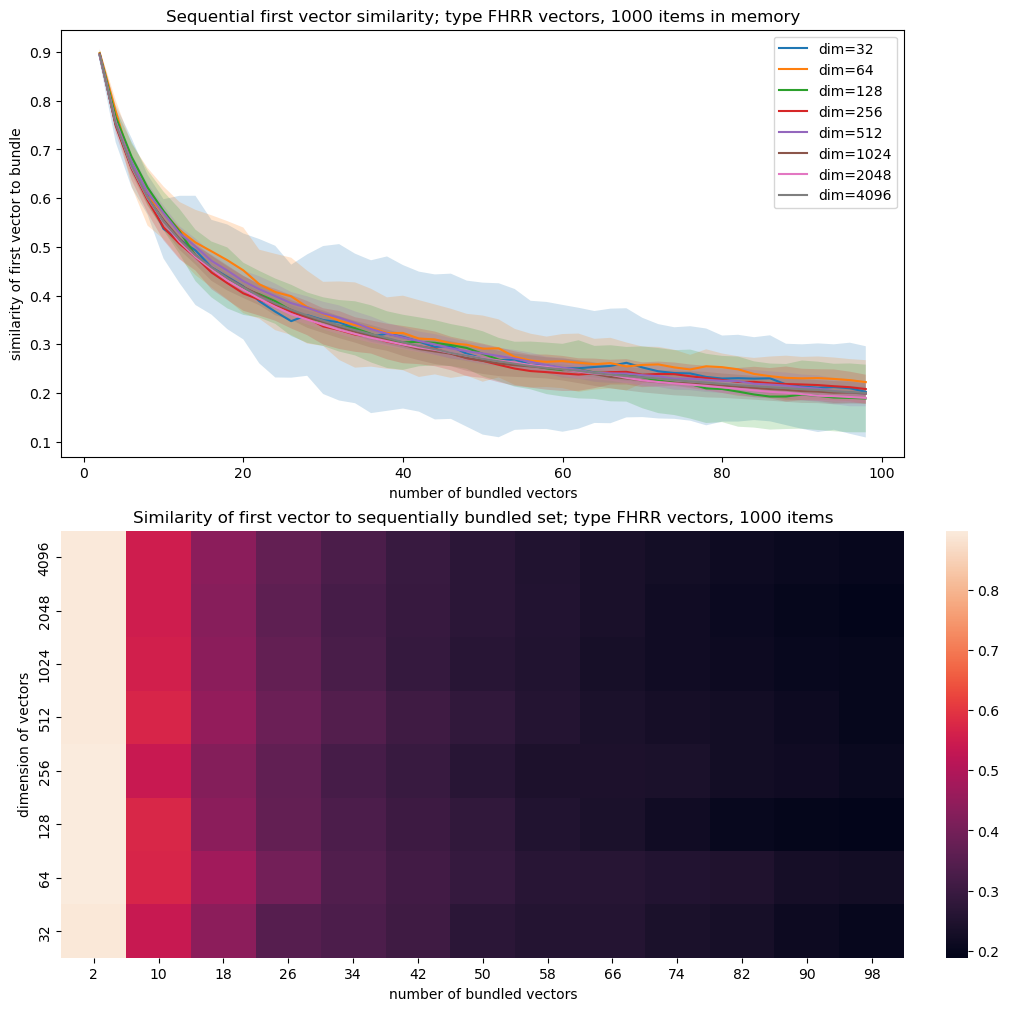

In [83]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10), layout='constrained')

line_ax = ax[0]
heatmap_ax = ax[1]

for d_idx in range(len(DIMENSIONS)):
    line_ax.plot(BUNDLE_SIZES, sim_first_vector_mean[d_idx, :], label=f'dim={DIMENSIONS[d_idx]}')
    line_ax.fill_between(BUNDLE_SIZES, sim_first_vector_mean[d_idx, :] - sim_first_vector_std[d_idx, :], sim_first_vector_mean[d_idx, :] + sim_first_vector_std[d_idx, :], alpha=0.2)
line_ax.legend()
line_ax.set_xlabel('number of bundled vectors')
line_ax.set_ylabel('similarity of first vector to bundle')
line_ax.set_title(f'Sequential first vector similarity; type {vsa_type} vectors, {item_memory_size} items in memory')

heatmap_ax = sns.heatmap(sim_first_vector_mean.numpy()[::-1, ::4], xticklabels=BUNDLE_SIZES[::4], yticklabels=DIMENSIONS[::-1], ax=heatmap_ax)
heatmap_ax.set_title(f'Similarity of first vector to sequentially bundled set; type {vsa_type} vectors, {item_memory_size} items')
heatmap_ax.set_xlabel('number of bundled vectors')
heatmap_ax.set_ylabel('dimension of vectors')


  Plot if first vector can be retrieved from the bundled vector

Text(26.292, 0.5, 'dimension of vectors')

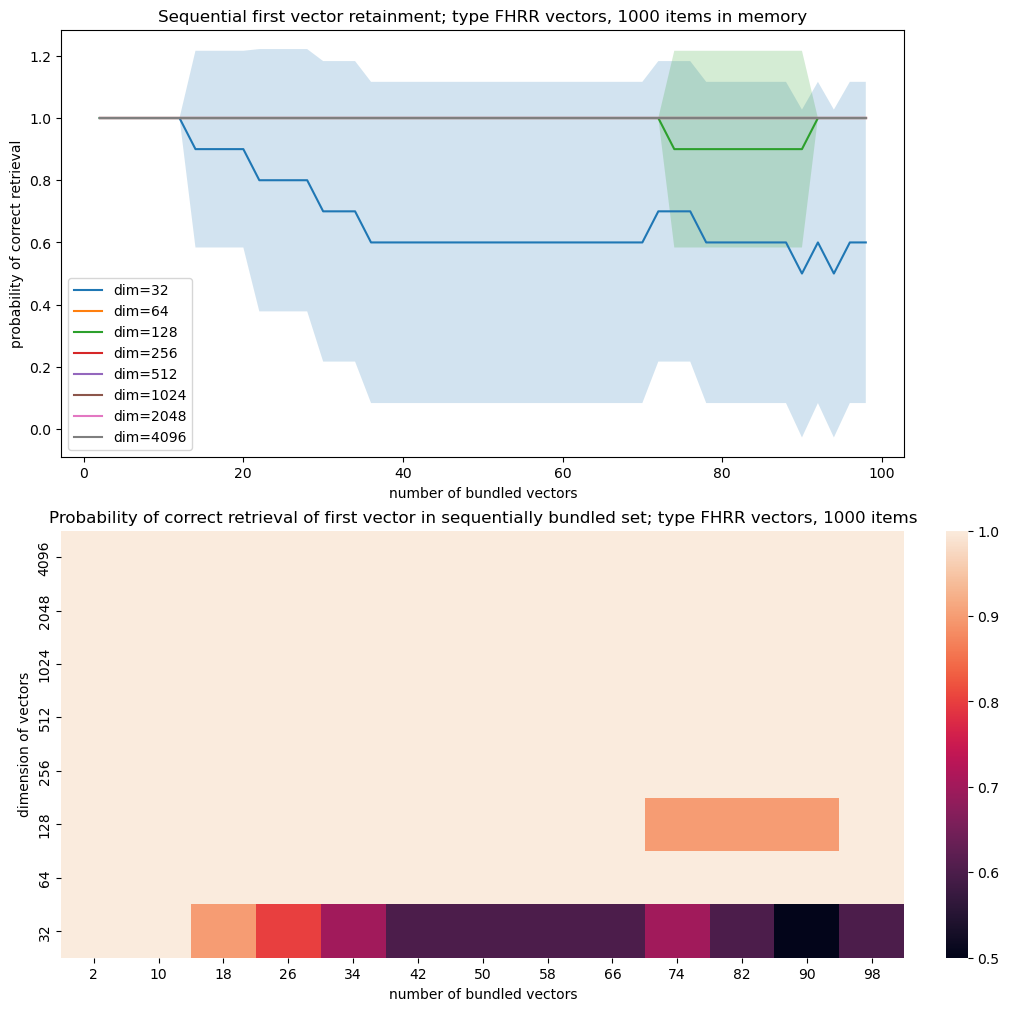

In [84]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10), layout='constrained')

line_ax = ax[0]
heatmap_ax = ax[1]

for d_idx in range(len(DIMENSIONS)):
    line_ax.plot(BUNDLE_SIZES, retrieval_first_vector_mean[d_idx, :], label=f'dim={DIMENSIONS[d_idx]}')
    line_ax.fill_between(BUNDLE_SIZES, retrieval_first_vector_mean[d_idx, :] - retrieval_first_vector_std[d_idx, :], retrieval_first_vector_mean[d_idx, :] + retrieval_first_vector_std[d_idx, :], alpha=0.2)
line_ax.legend()
line_ax.set_xlabel('number of bundled vectors')
line_ax.set_ylabel('probability of correct retrieval')
line_ax.set_title(f'Sequential first vector retainment; type {vsa_type} vectors, {item_memory_size} items in memory')

heatmap_ax = sns.heatmap(retrieval_first_vector_mean.numpy()[::-1, ::4], xticklabels=BUNDLE_SIZES[::4], yticklabels=DIMENSIONS[::-1], ax=heatmap_ax)
heatmap_ax.set_title(f'Probability of correct retrieval of first vector in sequentially bundled set; type {vsa_type} vectors, {item_memory_size} items')
heatmap_ax.set_xlabel('number of bundled vectors')
heatmap_ax.set_ylabel('dimension of vectors')
